In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import shutil
import os
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle

In [3]:
shutil.copytree('drive/MyDrive/JHU_Courses/Deep_Learning/Project/frames_1fps_resize_zip', 'frames_1fps_resize_zip')

'frames_1fps_resize_zip'

In [4]:
cd frames_1fps_resize_zip

/content/frames_1fps_resize_zip


In [5]:
!unzip frames-1fps-resize.zip

Streaming output truncated to the last 5000 lines.
  inflating: frames-1fps-resize/video79/video79-1123.jpg  
  inflating: frames-1fps-resize/video79/video79-1124.jpg  
  inflating: frames-1fps-resize/video79/video79-1125.jpg  
  inflating: frames-1fps-resize/video79/video79-1126.jpg  
  inflating: frames-1fps-resize/video79/video79-1127.jpg  
  inflating: frames-1fps-resize/video79/video79-1128.jpg  
  inflating: frames-1fps-resize/video79/video79-1129.jpg  
  inflating: frames-1fps-resize/video79/video79-113.jpg  
  inflating: frames-1fps-resize/video79/video79-1130.jpg  
  inflating: frames-1fps-resize/video79/video79-1131.jpg  
  inflating: frames-1fps-resize/video79/video79-1132.jpg  
  inflating: frames-1fps-resize/video79/video79-1133.jpg  
  inflating: frames-1fps-resize/video79/video79-1134.jpg  
  inflating: frames-1fps-resize/video79/video79-1135.jpg  
  inflating: frames-1fps-resize/video79/video79-1136.jpg  
  inflating: frames-1fps-resize/video79/video79-1137.jpg  
  infl

In [6]:
cd ..

/content


In [7]:
project_path = "drive/MyDrive/JHU_Courses/Deep_Learning/Project"

In [8]:
# get paths and labels
img_dir = 'frames_1fps_resize_zip/frames-1fps-resize/'
tool_dir = project_path+'/Dataset/cholec80/tool_annotations'
phase_dir = project_path+'/Dataset/cholec80/phase_annotations'

def get_dirs(root_dir):
    file_paths = []
    file_names = []
    for lists in os.listdir(root_dir):
        path = os.path.join(root_dir, lists)
        if os.path.isdir(path):
            file_paths.append(path)
            file_names.append(os.path.basename(path))
    file_names.sort()
    file_paths.sort()
    return file_names, file_paths

def get_files(root_dir):
    file_paths = []
    file_names = []
    for lists in os.listdir(root_dir):
        path = os.path.join(root_dir, lists)
        if not os.path.isdir(path):
            file_paths.append(path)
            file_names.append(os.path.basename(path))
    file_names.sort()
    file_paths.sort()
    return file_names, file_paths

img_dir_names, img_dir_paths = get_dirs(img_dir)
tool_file_names, tool_file_paths = get_files(tool_dir)
phase_file_names, phase_file_paths = get_files(phase_dir)

phase_dict = {}
phase_dict_key = ['Preparation', 'CalotTriangleDissection', 'ClippingCutting', 'GallbladderDissection', 'GallbladderPackaging', 'CleaningCoagulation', 'GallbladderRetraction']
for i in range(len(phase_dict_key)):
    phase_dict[phase_dict_key[i]] = i
print(phase_dict)

all_info_all = []

for j in range(len(tool_file_names)):
    last_tool_index = ''
    last_phase_index = ''
    tool_file = open(tool_file_paths[j])
    phase_file = open(phase_file_paths[j])
    tool_count = 0
    phase_count = 0
    info_all = []
    for tool_line in tool_file:
        tool_count += 1
        if tool_count > 1:
            tool_split = tool_line.split()
            info_each = []
            img_file_each_path = os.path.join(img_dir_paths[j], img_dir_names[j] + '-' + str(tool_count - 1) + '.jpg')
            info_each.append(img_file_each_path)
            for l in range(1, len(tool_split)):
                info_each.append(int(tool_split[l]))
                last_tool_index = tool_split[0]
            info_all.append(info_each)
            #print(info_each)
    for phase_line in phase_file:
        phase_count += 1
        if phase_count % 25 == 2 and (phase_count // 25) < len(info_all):
            phase_split = phase_line.split()
            info_all[phase_count // 25].append(phase_dict[phase_split[1]])
            # print(info_all[phase_count // 25])
            last_phase_index = phase_split[0]
    print('the{:4d}th tool: {:6d} index_error{:2d}'.format(j, tool_count - 1, int(last_tool_index) - int(last_phase_index)))

    #print(len(info_all))
    all_info_all.append(info_all)

with open('cholec80.pkl', 'wb') as f:
    pickle.dump(all_info_all, f)

with open('cholec80.pkl', 'rb') as f:
    all_info = pickle.load(f)

print(all_info[0][0])
print(all_info[79][0])

train_file_paths = []
test_file_paths = []
val_file_paths = []
val_labels = []
train_labels = []
test_labels = []

train_num_each = []
val_num_each = []
test_num_each = []

for i in range(32):
    train_num_each.append(len(all_info[i]))
    for j in range(len(all_info[i])):
        train_file_paths.append(all_info[i][j][0])
        train_labels.append(all_info[i][j][1:])

print(len(train_file_paths))
print(len(train_labels))

for i in range(32, 40):
    val_num_each.append(len(all_info[i]))
    for j in range(len(all_info[i])):
        val_file_paths.append(all_info[i][j][0])
        val_labels.append(all_info[i][j][1:])

print(len(val_file_paths))
print(len(val_labels))

for i in range(40, 80):
    test_num_each.append(len(all_info[i]))
    for j in range(len(all_info[i])):
        test_file_paths.append(all_info[i][j][0])
        test_labels.append(all_info[i][j][1:])

print(len(test_file_paths))
print(len(test_labels))

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_file_paths)
train_val_test_paths_labels.append(val_file_paths)
train_val_test_paths_labels.append(test_file_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)
train_val_test_paths_labels.append(test_labels)

train_val_test_paths_labels.append(train_num_each)
train_val_test_paths_labels.append(val_num_each)
train_val_test_paths_labels.append(test_num_each)

with open('train_val_test_paths_labels.pkl', 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

{'Preparation': 0, 'CalotTriangleDissection': 1, 'ClippingCutting': 2, 'GallbladderDissection': 3, 'GallbladderPackaging': 4, 'CleaningCoagulation': 5, 'GallbladderRetraction': 6}
the   0th tool:   1733 index_error 0
the   1th tool:   2839 index_error 0
the   2th tool:   5828 index_error 0
the   3th tool:   1522 index_error 0
the   4th tool:   2344 index_error 0
the   5th tool:   2153 index_error 0
the   6th tool:   4557 index_error 0
the   7th tool:   1519 index_error 0
the   8th tool:   2702 index_error 0
the   9th tool:   1749 index_error 0
the  10th tool:   3220 index_error 0
the  11th tool:   1090 index_error 0
the  12th tool:    981 index_error 0
the  13th tool:   1708 index_error 0
the  14th tool:   2058 index_error 0
the  15th tool:   2957 index_error 0
the  16th tool:   1304 index_error 0
the  17th tool:   1942 index_error 0
the  18th tool:   2424 index_error 0
the  19th tool:   1449 index_error 0
the  20th tool:   1258 index_error 0
the  21th tool:   1532 index_error 0
the  2

In [9]:
execfile(project_path+"/two_networks_two_tasks/utils.py")

In [10]:
execfile(project_path+"/two_networks_two_tasks/Model.py")

In [11]:
# param
train_batch_size = 40
val_batch_size = 8
test_batch_size = 8
workers = 2
learning_rate = 1e-3
epochs = 25

train_batch_size = 100
val_batch_size = 20
test_batch_size = 20
workers=mp.cpu_count()
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
# Load Data
train_dataset, train_num_each, val_dataset, val_num_each, test_dataset, test_num_each = get_data('train_val_test_paths_labels.pkl')
train_loader = DataLoader(train_dataset,batch_size=train_batch_size,shuffle=True,num_workers=workers,pin_memory=False)
val_loader = DataLoader(val_dataset,batch_size=val_batch_size,shuffle=True,num_workers=workers,pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False,num_workers=workers, pin_memory=False)

train_paths  :  71000
train_labels :  71000
valid_paths  :  15304
valid_labels :  15304
test_paths   :  98194
test_labels  :  98194


In [13]:
# Model
model = LSTM_ResNet_CL()
model.cuda()

# loss_f optimizer
tool_loss_f = nn.BCEWithLogitsLoss(size_average=False)
phase_loss_f = nn.CrossEntropyLoss(size_average=False)
p2t_loss_f = nn.KLDivLoss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 217MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.for

In [14]:
loss_log = pd.DataFrame([], index=[], columns=['Epoch', 'Train Tool Loss', 'Val Tool Loss','Test Tool Loss',
                                                   'Train Phase Loss', 'Val Phase Loss', 'Test Phase Loss'])
acc_log = pd.DataFrame([], index=[], columns=['Epoch', 'Train Tool Acc', 'Val Tool Acc','Test Tool Acc',
                                                'Train Phase Acc', 'Val Phase Acc', 'Test Phase Acc'])

In [15]:
Best_Acc = 0.0

In [16]:
for epoch in range(epochs):
  print("epoch" + str(epoch))
  train_tool_loss_list = []
  train_tool_acc_list = []
  train_phase_loss_list = []
  train_phase_acc_list = []

  val_tool_loss_list = []
  val_tool_acc_list = []
  val_phase_loss_list = []
  val_phase_acc_list = []

  test_tool_loss_list = []
  test_tool_acc_list = []
  test_phase_loss_list = []
  test_phase_acc_list = []
  # train
  model.train()
  for data in tqdm(train_loader):
    inputs, tool_labels, phase_labels = data
    inputs = Variable(inputs.cuda())
    tool_labels = Variable(tool_labels.cuda())
    tool_labels = tool_labels.type(torch.FloatTensor).cuda()
    phase_labels = Variable(phase_labels.cuda())

    optimizer.zero_grad()
    tool_output, phase_output, p2t_output = model(inputs)

    tool_loss = tool_loss_f(tool_output, tool_labels)
    phase_loss = phase_loss_f(phase_output, phase_labels)

    # p2t loss
    tool_output_sigmoid = F.sigmoid(tool_output)
    p2t_output_sigmoid = F.sigmoid(p2t_output)
    p2t_loss = torch.abs(p2t_loss_f(tool_output_sigmoid,p2t_output_sigmoid))

    loss = tool_loss + phase_loss + p2t_loss
    loss.backward()
    optimizer.step()

  # valid
  model.eval()
  for data in tqdm(train_loader):
    inputs, tool_labels, phase_labels = data
    inputs = Variable(inputs.cuda())
    tool_labels = Variable(tool_labels.cuda())
    tool_labels = tool_labels.type(torch.FloatTensor).cuda()
    phase_labels = Variable(phase_labels.cuda())

    tool_output, phase_output, p2t_output = model(inputs)

    tool_loss = tool_loss_f(tool_output, tool_labels)
    phase_loss = phase_loss_f(phase_output, phase_labels)
    train_tool_loss_list.append(tool_loss.item())
    train_phase_loss_list.append(phase_loss.item())

    # tool acc
    tool_output = F.sigmoid(tool_output)
    tool_output[tool_output >= 0.5] = 1.0
    tool_output[tool_output < 0.5] = 0.0
    acc = torch.sum(tool_output == tool_labels).float() / len(tool_labels) / 7
    train_tool_acc_list.append(acc.data.cpu().numpy())

    # phase acc
    _, phase_preds = torch.max(phase_output, 1)
    acc = torch.sum(phase_preds == phase_labels).float() / len(phase_labels)
    train_phase_acc_list.append(acc.data.cpu().numpy())

  print('Train Tool Loss:{:.4f} Train Phase Loss:{:.4f}'.format(np.mean(train_tool_loss_list),np.mean(train_phase_loss_list)))
  print('Train Tool Acc:{:.4f} Train Phase Acc:{:.4f}'.format(np.mean(train_tool_acc_list),np.mean(train_phase_acc_list)))

  for data in tqdm(val_loader):
    inputs, tool_labels, phase_labels = data
    inputs = Variable(inputs.cuda())
    tool_labels = Variable(tool_labels.cuda())
    tool_labels = tool_labels.type(torch.FloatTensor).cuda()
    phase_labels = Variable(phase_labels.cuda())

    tool_output, phase_output, p2t_output = model(inputs)

    tool_loss = tool_loss_f(tool_output, tool_labels)
    phase_loss = phase_loss_f(phase_output, phase_labels)
    val_tool_loss_list.append(tool_loss.item())
    val_phase_loss_list.append(phase_loss.item())

    # tool acc
    tool_output = F.sigmoid(tool_output)
    tool_output[tool_output >= 0.5] = 1.0
    tool_output[tool_output < 0.5] = 0.0
    acc = torch.sum(tool_output == tool_labels).float() / len(tool_labels) / 7
    val_tool_acc_list.append(acc.data.cpu().numpy())

    # phase acc
    _, phase_preds = torch.max(phase_output, 1)
    acc = torch.sum(phase_preds == phase_labels).float() / len(phase_labels)
    val_phase_acc_list.append(acc.data.cpu().numpy())

  print('Val Tool Loss:{:.4f} Val Phase Loss:{:.4f}'.format(np.mean(val_tool_loss_list),
                                                                np.mean(val_phase_loss_list)))
  print('Val Tool Acc:{:.4f} Val Phase Acc:{:.4f}'.format(np.mean(val_tool_acc_list),
                                                              np.mean(val_phase_acc_list)))

  for data in tqdm(test_loader):
    inputs, tool_labels, phase_labels = data
    inputs = Variable(inputs.cuda())
    tool_labels = Variable(tool_labels.cuda())
    tool_labels = tool_labels.type(torch.FloatTensor).cuda()
    phase_labels = Variable(phase_labels.cuda())

    tool_output, phase_output, p2t_output = model(inputs)

    tool_loss = tool_loss_f(tool_output, tool_labels)
    phase_loss = phase_loss_f(phase_output, phase_labels)
    test_tool_loss_list.append(tool_loss.item())
    test_phase_loss_list.append(phase_loss.item())

    # tool acc
    tool_output = F.sigmoid(tool_output)
    tool_output[tool_output >= 0.5] = 1.0
    tool_output[tool_output < 0.5] = 0.0
    acc = torch.sum(tool_output == tool_labels).float() / len(tool_labels) / 7
    test_tool_acc_list.append(acc.data.cpu().numpy())

    # phase acc
    _, phase_preds = torch.max(phase_output, 1)
    acc = torch.sum(phase_preds == phase_labels).float() / len(phase_labels)
    test_phase_acc_list.append(acc.data.cpu().numpy())

  print('Test Tool Loss:{:.4f} Test Phase Loss:{:.4f}'.format(np.mean(test_tool_loss_list),
                                                                np.mean(test_phase_loss_list)))
  print('Test Tool Acc:{:.4f} Test Phase Acc:{:.4f}'.format(np.mean(test_tool_acc_list),
                                                              np.mean(test_phase_acc_list)))

  # log
  tmp = pd.Series([epoch,np.mean(train_tool_loss_list),np.mean(val_tool_loss_list),np.mean(test_tool_loss_list),
                    np.mean(train_phase_loss_list),np.mean(val_phase_loss_list),np.mean(test_phase_loss_list)],
                  index=['Epoch', 'Train Tool Loss', 'Val Tool Loss','Test Tool Loss',
                                              'Train Phase Loss', 'Val Phase Loss', 'Test Phase Loss'])
  loss_log = loss_log.append(tmp, ignore_index=True)
  os.makedirs(project_path+'/two_networks_two_tasks/log',exist_ok=True)
  loss_log.to_csv(project_path+'/two_networks_two_tasks/log/multi_tasks_cl_loss_log.csv',index=False)

  tmp = pd.Series([epoch,np.mean(train_tool_acc_list),np.mean(val_tool_acc_list),np.mean(test_tool_acc_list),
                    np.mean(train_phase_acc_list),np.mean(val_phase_acc_list),np.mean(test_phase_acc_list)],
                  index=['Epoch', 'Train Tool Acc', 'Val Tool Acc','Test Tool Acc',
                                              'Train Phase Acc', 'Val Phase Acc', 'Test Phase Acc'])
  acc_log = acc_log.append(tmp, ignore_index=True)
  acc_log.to_csv(project_path+'/two_networks_two_tasks/log/multi_tasks_cl_acc_log.csv',index=False)

  # save
  if np.mean(test_phase_acc_list) > Best_Acc:
    Best_Acc = np.mean(test_phase_acc_list)
    state_dict = model.state_dict()
    torch.save(state_dict, project_path+'/two_networks_two_tasks/log/multi_tasks_cl_model.pkl')
    print('Successly Save Weight!!')


epoch0


100%|██████████| 710/710 [00:45<00:00, 15.55it/s]


Train Tool Loss:65.9173 Train Phase Loss:52.1854
Train Tool Acc:0.9657 Train Phase Acc:0.8162


100%|██████████| 766/766 [00:15<00:00, 50.92it/s]


Val Tool Loss:16.8498 Val Phase Loss:17.3702
Val Tool Acc:0.9528 Val Phase Acc:0.7023


100%|██████████| 4910/4910 [01:33<00:00, 52.49it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)


Test Tool Loss:25.1027 Test Phase Loss:20.0662
Test Tool Acc:0.9378 Test Phase Acc:0.6469


<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Successly Save Weight!!
epoch1


100%|██████████| 710/710 [00:45<00:00, 15.53it/s]


Train Tool Loss:46.8301 Train Phase Loss:29.1169
Train Tool Acc:0.9755 Train Phase Acc:0.8975


100%|██████████| 766/766 [00:15<00:00, 50.55it/s]


Val Tool Loss:17.7253 Val Phase Loss:13.7455
Val Tool Acc:0.9508 Val Phase Acc:0.7711


100%|██████████| 4910/4910 [01:34<00:00, 52.15it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:18.4920 Test Phase Loss:16.4930
Test Tool Acc:0.9549 Test Phase Acc:0.7261
Successly Save Weight!!
epoch2


100%|██████████| 710/710 [00:45<00:00, 15.59it/s]


Train Tool Loss:34.2592 Train Phase Loss:22.5003
Train Tool Acc:0.9820 Train Phase Acc:0.9211


100%|██████████| 766/766 [00:15<00:00, 50.15it/s]


Val Tool Loss:14.6955 Val Phase Loss:14.4570
Val Tool Acc:0.9620 Val Phase Acc:0.7627


100%|██████████| 4910/4910 [01:34<00:00, 51.90it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:19.1242 Test Phase Loss:18.0834
Test Tool Acc:0.9578 Test Phase Acc:0.7200
epoch3


100%|██████████| 710/710 [00:45<00:00, 15.54it/s]


Train Tool Loss:36.1884 Train Phase Loss:19.9367
Train Tool Acc:0.9808 Train Phase Acc:0.9299


100%|██████████| 766/766 [00:15<00:00, 50.11it/s]


Val Tool Loss:15.5514 Val Phase Loss:14.5554
Val Tool Acc:0.9610 Val Phase Acc:0.7783


100%|██████████| 4910/4910 [01:33<00:00, 52.25it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:20.3607 Test Phase Loss:16.8956
Test Tool Acc:0.9549 Test Phase Acc:0.7465
Successly Save Weight!!
epoch4


100%|██████████| 710/710 [00:45<00:00, 15.57it/s]


Train Tool Loss:30.0723 Train Phase Loss:19.4709
Train Tool Acc:0.9842 Train Phase Acc:0.9302


100%|██████████| 766/766 [00:15<00:00, 50.06it/s]


Val Tool Loss:12.5914 Val Phase Loss:16.4060
Val Tool Acc:0.9662 Val Phase Acc:0.7492


100%|██████████| 4910/4910 [01:35<00:00, 51.55it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:20.2150 Test Phase Loss:17.6306
Test Tool Acc:0.9567 Test Phase Acc:0.7319
epoch5


100%|██████████| 710/710 [00:45<00:00, 15.50it/s]


Train Tool Loss:25.1300 Train Phase Loss:14.6611
Train Tool Acc:0.9872 Train Phase Acc:0.9490


100%|██████████| 766/766 [00:15<00:00, 50.05it/s]


Val Tool Loss:14.1577 Val Phase Loss:13.5347
Val Tool Acc:0.9637 Val Phase Acc:0.7807


100%|██████████| 4910/4910 [01:34<00:00, 51.83it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:21.3083 Test Phase Loss:17.2890
Test Tool Acc:0.9554 Test Phase Acc:0.7436
epoch6


100%|██████████| 710/710 [00:45<00:00, 15.50it/s]


Train Tool Loss:23.0581 Train Phase Loss:14.7769
Train Tool Acc:0.9881 Train Phase Acc:0.9469


100%|██████████| 766/766 [00:14<00:00, 51.09it/s]


Val Tool Loss:12.1601 Val Phase Loss:15.0242
Val Tool Acc:0.9701 Val Phase Acc:0.7875


100%|██████████| 4910/4910 [01:35<00:00, 51.57it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:23.3807 Test Phase Loss:19.5835
Test Tool Acc:0.9539 Test Phase Acc:0.7360
epoch7


100%|██████████| 710/710 [00:45<00:00, 15.49it/s]


Train Tool Loss:21.7200 Train Phase Loss:12.0984
Train Tool Acc:0.9886 Train Phase Acc:0.9572


100%|██████████| 766/766 [00:15<00:00, 49.73it/s]


Val Tool Loss:14.1825 Val Phase Loss:14.6915
Val Tool Acc:0.9652 Val Phase Acc:0.7828


100%|██████████| 4910/4910 [01:36<00:00, 50.96it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:19.8107 Test Phase Loss:20.0608
Test Tool Acc:0.9580 Test Phase Acc:0.7293
epoch8


100%|██████████| 710/710 [00:45<00:00, 15.45it/s]


Train Tool Loss:17.5207 Train Phase Loss:9.8334
Train Tool Acc:0.9910 Train Phase Acc:0.9645


100%|██████████| 766/766 [00:15<00:00, 49.34it/s]


Val Tool Loss:14.0822 Val Phase Loss:15.0232
Val Tool Acc:0.9676 Val Phase Acc:0.7879


100%|██████████| 4910/4910 [01:35<00:00, 51.17it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:24.2113 Test Phase Loss:18.3852
Test Tool Acc:0.9571 Test Phase Acc:0.7527
Successly Save Weight!!
epoch9


100%|██████████| 710/710 [00:46<00:00, 15.39it/s]


Train Tool Loss:16.8494 Train Phase Loss:9.7966
Train Tool Acc:0.9915 Train Phase Acc:0.9652


100%|██████████| 766/766 [00:15<00:00, 49.65it/s]


Val Tool Loss:13.0398 Val Phase Loss:14.5331
Val Tool Acc:0.9679 Val Phase Acc:0.7931


100%|██████████| 4910/4910 [01:35<00:00, 51.38it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:21.1401 Test Phase Loss:18.3506
Test Tool Acc:0.9568 Test Phase Acc:0.7447
epoch10


100%|██████████| 710/710 [00:45<00:00, 15.46it/s]


Train Tool Loss:17.3133 Train Phase Loss:8.6512
Train Tool Acc:0.9910 Train Phase Acc:0.9697


100%|██████████| 766/766 [00:15<00:00, 50.76it/s]


Val Tool Loss:13.4661 Val Phase Loss:16.3508
Val Tool Acc:0.9676 Val Phase Acc:0.7774


100%|██████████| 4910/4910 [01:34<00:00, 51.91it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:23.0886 Test Phase Loss:20.6296
Test Tool Acc:0.9561 Test Phase Acc:0.7400
epoch11


100%|██████████| 710/710 [00:45<00:00, 15.55it/s]


Train Tool Loss:17.8586 Train Phase Loss:8.9127
Train Tool Acc:0.9909 Train Phase Acc:0.9685


100%|██████████| 766/766 [00:15<00:00, 50.95it/s]


Val Tool Loss:17.9898 Val Phase Loss:16.0260
Val Tool Acc:0.9630 Val Phase Acc:0.7883


100%|██████████| 4910/4910 [01:33<00:00, 52.26it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:20.6976 Test Phase Loss:19.8707
Test Tool Acc:0.9596 Test Phase Acc:0.7437
epoch12


100%|██████████| 710/710 [00:45<00:00, 15.54it/s]


Train Tool Loss:13.8685 Train Phase Loss:7.0887
Train Tool Acc:0.9927 Train Phase Acc:0.9743


100%|██████████| 766/766 [00:15<00:00, 49.97it/s]


Val Tool Loss:15.8247 Val Phase Loss:20.0129
Val Tool Acc:0.9645 Val Phase Acc:0.7600


100%|██████████| 4910/4910 [01:34<00:00, 52.03it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:22.1782 Test Phase Loss:21.6033
Test Tool Acc:0.9588 Test Phase Acc:0.7401
epoch13


100%|██████████| 710/710 [00:45<00:00, 15.52it/s]


Train Tool Loss:19.5210 Train Phase Loss:7.3673
Train Tool Acc:0.9896 Train Phase Acc:0.9727


100%|██████████| 766/766 [00:15<00:00, 50.37it/s]


Val Tool Loss:22.3581 Val Phase Loss:18.2031
Val Tool Acc:0.9542 Val Phase Acc:0.7623


100%|██████████| 4910/4910 [01:33<00:00, 52.31it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:22.8604 Test Phase Loss:20.5451
Test Tool Acc:0.9559 Test Phase Acc:0.7350
epoch14


100%|██████████| 710/710 [00:45<00:00, 15.59it/s]


Train Tool Loss:11.7535 Train Phase Loss:5.7319
Train Tool Acc:0.9939 Train Phase Acc:0.9797


100%|██████████| 766/766 [00:15<00:00, 50.00it/s]


Val Tool Loss:14.4463 Val Phase Loss:14.5543
Val Tool Acc:0.9702 Val Phase Acc:0.8116


100%|██████████| 4910/4910 [01:34<00:00, 52.13it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:27.0417 Test Phase Loss:20.7710
Test Tool Acc:0.9558 Test Phase Acc:0.7502
epoch15


100%|██████████| 710/710 [00:45<00:00, 15.47it/s]


Train Tool Loss:10.9412 Train Phase Loss:5.7795
Train Tool Acc:0.9944 Train Phase Acc:0.9794


100%|██████████| 766/766 [00:15<00:00, 50.00it/s]


Val Tool Loss:13.8829 Val Phase Loss:17.0530
Val Tool Acc:0.9689 Val Phase Acc:0.7888


100%|██████████| 4910/4910 [01:33<00:00, 52.41it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:26.3701 Test Phase Loss:21.1335
Test Tool Acc:0.9550 Test Phase Acc:0.7506
epoch16


100%|██████████| 710/710 [00:45<00:00, 15.47it/s]


Train Tool Loss:11.1591 Train Phase Loss:5.6180
Train Tool Acc:0.9942 Train Phase Acc:0.9795


100%|██████████| 766/766 [00:15<00:00, 49.86it/s]


Val Tool Loss:16.6190 Val Phase Loss:16.8986
Val Tool Acc:0.9648 Val Phase Acc:0.7917


100%|██████████| 4910/4910 [01:36<00:00, 50.82it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:25.2631 Test Phase Loss:22.1700
Test Tool Acc:0.9548 Test Phase Acc:0.7464
epoch17


100%|██████████| 710/710 [00:45<00:00, 15.48it/s]


Train Tool Loss:9.8270 Train Phase Loss:5.1418
Train Tool Acc:0.9950 Train Phase Acc:0.9818


100%|██████████| 766/766 [00:15<00:00, 50.01it/s]


Val Tool Loss:16.7242 Val Phase Loss:17.3983
Val Tool Acc:0.9645 Val Phase Acc:0.8000


100%|██████████| 4910/4910 [01:35<00:00, 51.18it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:24.4742 Test Phase Loss:22.4210
Test Tool Acc:0.9584 Test Phase Acc:0.7529
Successly Save Weight!!
epoch18


100%|██████████| 710/710 [00:45<00:00, 15.48it/s]


Train Tool Loss:10.7320 Train Phase Loss:4.8227
Train Tool Acc:0.9945 Train Phase Acc:0.9833


100%|██████████| 766/766 [00:15<00:00, 49.45it/s]


Val Tool Loss:16.9550 Val Phase Loss:17.7882
Val Tool Acc:0.9637 Val Phase Acc:0.7908


100%|██████████| 4910/4910 [01:35<00:00, 51.62it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:23.6651 Test Phase Loss:22.5211
Test Tool Acc:0.9576 Test Phase Acc:0.7473
epoch19


100%|██████████| 710/710 [00:45<00:00, 15.45it/s]


Train Tool Loss:8.3237 Train Phase Loss:3.8039
Train Tool Acc:0.9957 Train Phase Acc:0.9868


100%|██████████| 766/766 [00:15<00:00, 49.91it/s]


Val Tool Loss:15.9838 Val Phase Loss:18.0614
Val Tool Acc:0.9678 Val Phase Acc:0.7922


100%|██████████| 4910/4910 [01:35<00:00, 51.36it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:31.0538 Test Phase Loss:21.9877
Test Tool Acc:0.9522 Test Phase Acc:0.7593
Successly Save Weight!!
epoch20


100%|██████████| 710/710 [00:46<00:00, 15.43it/s]


Train Tool Loss:8.6519 Train Phase Loss:5.2372
Train Tool Acc:0.9956 Train Phase Acc:0.9817


100%|██████████| 766/766 [00:15<00:00, 49.44it/s]


Val Tool Loss:19.7099 Val Phase Loss:20.2566
Val Tool Acc:0.9626 Val Phase Acc:0.7782


100%|██████████| 4910/4910 [01:35<00:00, 51.46it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:30.4036 Test Phase Loss:25.3221
Test Tool Acc:0.9543 Test Phase Acc:0.7293
epoch21


100%|██████████| 710/710 [00:45<00:00, 15.50it/s]


Train Tool Loss:7.8697 Train Phase Loss:4.2121
Train Tool Acc:0.9961 Train Phase Acc:0.9858


100%|██████████| 766/766 [00:15<00:00, 49.60it/s]


Val Tool Loss:16.3799 Val Phase Loss:17.8052
Val Tool Acc:0.9662 Val Phase Acc:0.7933


100%|██████████| 4910/4910 [01:35<00:00, 51.31it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:26.3497 Test Phase Loss:23.0733
Test Tool Acc:0.9552 Test Phase Acc:0.7488
epoch22


100%|██████████| 710/710 [00:46<00:00, 15.41it/s]


Train Tool Loss:9.7552 Train Phase Loss:3.4924
Train Tool Acc:0.9950 Train Phase Acc:0.9877


100%|██████████| 766/766 [00:15<00:00, 48.49it/s]


Val Tool Loss:17.0641 Val Phase Loss:17.9286
Val Tool Acc:0.9674 Val Phase Acc:0.8033


100%|██████████| 4910/4910 [01:36<00:00, 51.05it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:32.4345 Test Phase Loss:23.1883
Test Tool Acc:0.9520 Test Phase Acc:0.7561
epoch23


100%|██████████| 710/710 [00:45<00:00, 15.52it/s]


Train Tool Loss:7.7004 Train Phase Loss:4.0550
Train Tool Acc:0.9961 Train Phase Acc:0.9852


100%|██████████| 766/766 [00:15<00:00, 49.62it/s]


Val Tool Loss:17.5371 Val Phase Loss:19.6688
Val Tool Acc:0.9657 Val Phase Acc:0.7749


100%|██████████| 4910/4910 [01:35<00:00, 51.15it/s]
<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:28.7389 Test Phase Loss:25.9740
Test Tool Acc:0.9561 Test Phase Acc:0.7306
epoch24


100%|██████████| 710/710 [00:45<00:00, 15.52it/s]


Train Tool Loss:7.2533 Train Phase Loss:3.0515
Train Tool Acc:0.9964 Train Phase Acc:0.9891


100%|██████████| 766/766 [00:15<00:00, 49.67it/s]


Val Tool Loss:16.9572 Val Phase Loss:18.0453
Val Tool Acc:0.9682 Val Phase Acc:0.7993


100%|██████████| 4910/4910 [01:35<00:00, 51.50it/s]

Test Tool Loss:31.6038 Test Phase Loss:23.9355
Test Tool Acc:0.9544 Test Phase Acc:0.7471



<ipython-input-16-c49420837324>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-c49420837324>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Best Result：
Test Tool Loss:31.0538 Test Phase Loss:21.9877
Test Tool Acc:0.9522 Test Phase Acc:0.7593

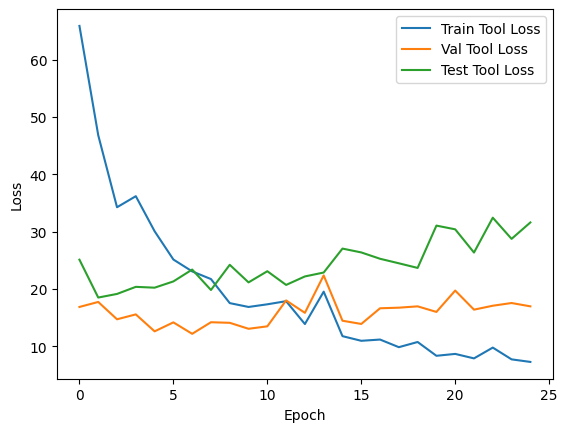

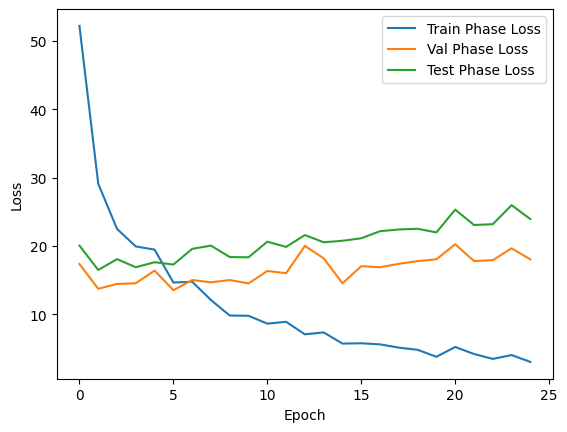

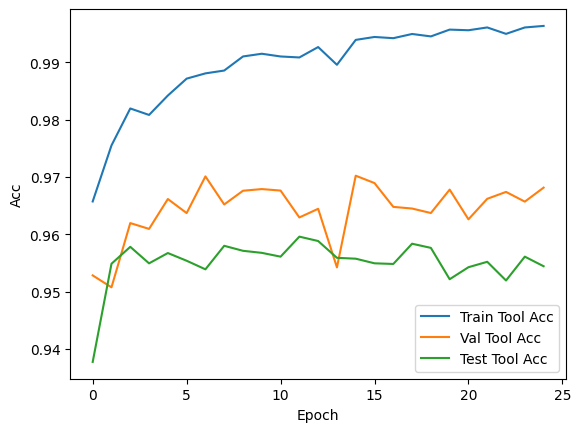

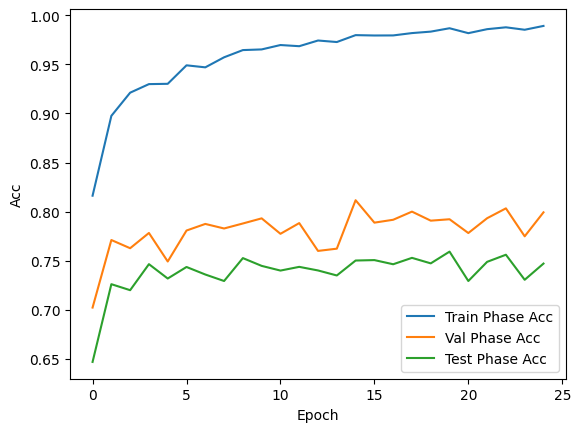

In [17]:
loss_data = pd.read_csv(project_path+'/two_networks_two_tasks/log/multi_tasks_cl_loss_log.csv')
# tool loss
train_tool_loss = loss_data['Train Tool Loss']
val_tool_loss = loss_data['Val Tool Loss']
test_tool_loss = loss_data['Test Tool Loss']
plt.plot(range(len(train_tool_loss)),train_tool_loss)
plt.plot(range(len(val_tool_loss)),val_tool_loss)
plt.plot(range(len(test_tool_loss)),test_tool_loss)
plt.legend(['Train Tool Loss','Val Tool Loss','Test Tool Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# phase loss
train_phase_loss = loss_data['Train Phase Loss']
val_phase_loss = loss_data['Val Phase Loss']
test_phase_loss = loss_data['Test Phase Loss']
plt.plot(range(len(train_phase_loss)), train_phase_loss)
plt.plot(range(len(val_phase_loss)), val_phase_loss)
plt.plot(range(len(test_phase_loss)), test_phase_loss)
plt.legend(['Train Phase Loss', 'Val Phase Loss', 'Test Phase Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

acc_data = pd.read_csv(project_path+'/two_networks_two_tasks/log/multi_tasks_cl_acc_log.csv')
# tool acc
train_tool_acc = acc_data['Train Tool Acc']
val_tool_acc = acc_data['Val Tool Acc']
test_tool_acc = acc_data['Test Tool Acc']
plt.plot(range(len(train_tool_acc)), train_tool_acc)
plt.plot(range(len(val_tool_acc)), val_tool_acc)
plt.plot(range(len(test_tool_acc)), test_tool_acc)
plt.legend(['Train Tool Acc', 'Val Tool Acc', 'Test Tool Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()
# phase acc
train_phase_acc = acc_data['Train Phase Acc']
val_phase_acc = acc_data['Val Phase Acc']
test_phase_acc = acc_data['Test Phase Acc']
plt.plot(range(len(train_phase_acc)), train_phase_acc)
plt.plot(range(len(val_phase_acc)), val_phase_acc)
plt.plot(range(len(test_phase_acc)), test_phase_acc)
plt.legend(['Train Phase Acc', 'Val Phase Acc', 'Test Phase Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()